In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [2]:
# Read the data for January. How many columns are there?
data = pd.read_parquet('yellow_tripdata_2023-01.parquet')
columns = data.columns
print(len(columns))

19


## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the standard deviation of the trips duration in January?

In [3]:
data['duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
std_duration = data['duration'].std()
print(std_duration)

42.59435124195458


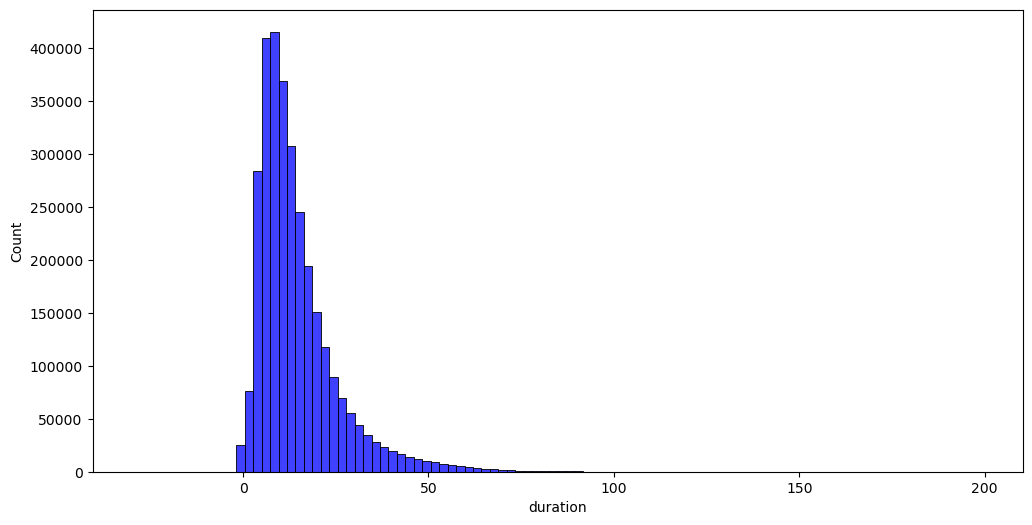

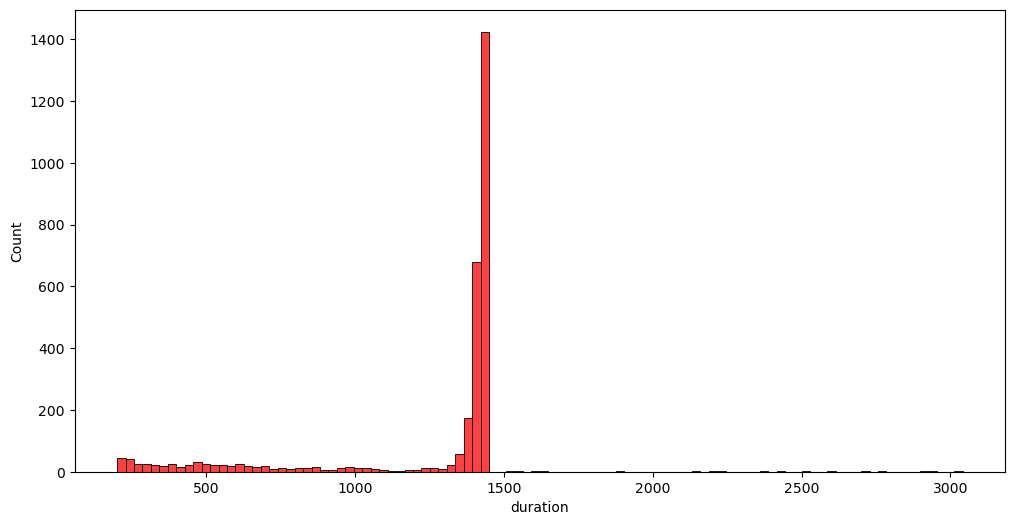

In [4]:
# show duration distribution from 0 to 200 minutes and from 200 to 10000 minutes on the same plot
plt.figure(figsize=(12, 6))
sns.histplot(data[data['duration'] < 200]['duration'], bins=100, color='blue', label='duration_normal')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data[(data['duration'] >= 200)&(data['duration'] < 4000)]['duration'], bins=100, color='red', label='duration_long')
plt.show()

## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [5]:
data_filtered = data[(data['duration'] >= 1) & (data['duration'] <= 60)].copy(deep=True)
fraction = len(data_filtered) / len(data) * 100
print(fraction)

98.1220282212598


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will 
  label encode them)
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [12]:
categorical = ['PULocationID', 'DOLocationID']
data_filtered[categorical] = data_filtered[categorical].astype(str)

train_dict = data_filtered[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
print(X_train.shape[1])

515


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters, where duration is the response variable
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [20]:
y_train = data_filtered['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(rmse)

7.649262776520412


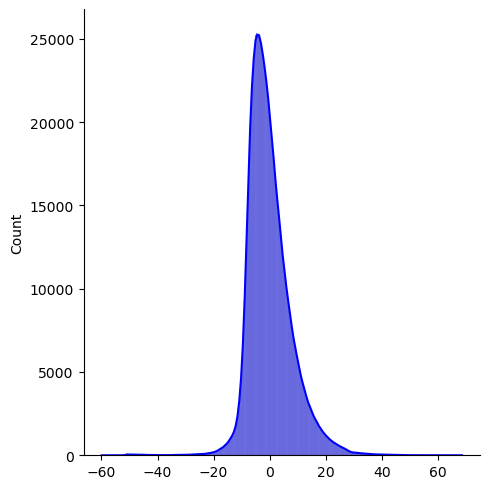

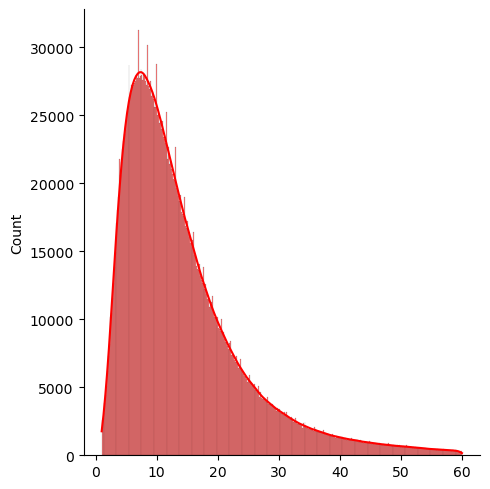

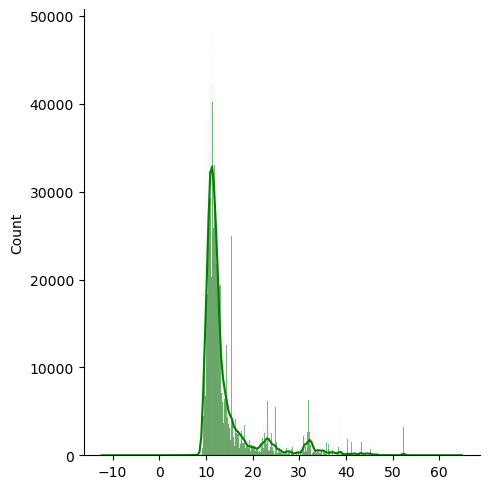

In [21]:
sns.displot(y_train - y_pred, kde=True, color='blue')
sns.displot(y_train, kde=True, color='red')
sns.displot(y_pred, kde=True, color='green')
plt.show()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023). 

What's the RMSE on validation?

In [22]:
test_data = pd.read_parquet('yellow_tripdata_2023-02.parquet')
test_data['duration'] = (test_data['tpep_dropoff_datetime'] - test_data['tpep_pickup_datetime']).dt.total_seconds() / 60

test_data_filtered = test_data[(test_data['duration'] >= 1) & (test_data['duration'] <= 60)].copy(deep=True)
test_data_filtered[categorical] = test_data_filtered[categorical].astype(str)
test_data = dv.transform(test_data_filtered[categorical].to_dict(orient='records'))

y_test = test_data_filtered['duration'].values
y_pred = lr.predict(test_data)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)



7.811802649882949
